In [54]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import os
from SGD.dynamics import Trainer
from SGD.data import DataGenerator
from SGD.plot_config import *
from SGD.utils import initialize_weights , velocity_field
from SGD.functions import activations
import matplotlib.pyplot as plt
import pickle   
apply_general_styles()

# Initial Test single walker

In [ ]:
d = 100
N_walkers = 3
teacher = "He3"
student = "tanh"
loss = "mse"
# lr = 0.001/d**2
w_teacher = np.random.randn(d)
w_teacher/=np.linalg.norm(w_teacher)
w_initial = np.random.randn(d)
w_initial/=np.linalg.norm(w_initial)
w_initial -= w_teacher * (w_initial @ w_teacher)
w_initial /= np.linalg.norm(w_initial)
w_initial = w_teacher*(1/np.sqrt(d)) + w_initial * np.sqrt((d-1)/d)

noise = 0.0
dataset_size = 5
p_repeat = 0.001



alpha = 0.1
lr = 5/d
N_steps = int(alpha*d)
print(f'N_steps = {N_steps}, lr = {lr:.2e}')
print(f"lr * d^2 = {lr * d*d:.2e}")

In [ ]:
# Initialize DataGenerator
data_generator = DataGenerator(d, teacher, w_teacher, noise=noise, dataset_size=dataset_size, p_repeat=p_repeat,mode='repeat')

# Extract Data as arrays
X , Y = data_generator.get_dataset(how='arrays')
data_init = (X[0],Y[0])

print(f"Data shape: X = {X.shape} , Y = {Y.shape}" )

# Initialize Trainer
trainer = Trainer(d, w_teacher, teacher, student, loss, lr, data_generator)

# Save data
data = {
    'overlap':[],
    'preactivations':[],
    'flags':[],
    'times':[],
    'grad':[],
    'ov_grad':[]
}
# Run evolution
print("Starting training...")
for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True,data_init=data_init)):
    condition_save = step % 1 == 0 or step == N_steps - 1 or flag != 0
    
    if condition_save:
        data['overlap'].append(np.dot(w_teacher, w_student))
        data['preactivations'].append(X @ w_student)
        data['flags'].append(flag)
        data['times'].append(step)
        data['grad'].append(np.linalg.norm(grad))
        data['ov_grad'].append(X @ grad)

    # condition = step % 100 == 0 or step == N_steps - 1
    condition = False
    if condition:
        print(f"Step {step + 1}/{N_steps}: overlap = {np.dot(w_teacher, w_student):.4f} : flag = {flag} : preactivations = {X @ w_student} ")
print("End training...")

for key in data:
    data[key] = np.array(data[key])
    print(f"{key} shape: {data[key].shape}")

In [ ]:
ncols = 1
nrows = 4


width = double_w
figsize = (width, width * 0.5)
col = colors[0]
cols_map = plt.get_cmap(cmaps[0])(np.linspace(0.5, 1, dataset_size))

fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)

for i , key in enumerate(['overlap','preactivations','grad','ov_grad']):
    ax = axes[i]
    ax.set_ylabel(key)
    times = data['times']/d
    # ax.set_xlim(right=100)
    if i == nrows-1 : ax.set_xlabel('SGD steps')
    if key == 'overlap': 
         ax.axhline(0.1, ls='--', color='gray', lw=0.7)
         ax.axhline(-(0.1), ls='--', color='gray', lw=0.7)
    flags = data['flags']
    for j in range(len(flags)-1):
        if flags[j] == 1:
            ax.axvline(times[j],color='gray',alpha=0.3,lw=0.2)
            
    if key == 'preactivations':
        for w in range(dataset_size):
                ax.plot(times,data[key][:,w],color=cols_map[w])
    else:
        ax.plot(times,data[key],color=col)


# Test multi walkers

In [ ]:
d = 2
teacher = "He3"
w_teacher = np.random.randn(d)
w_teacher/=np.linalg.norm(w_teacher)
N_walkers = 3
dataset_size = 9
p_repeat = 0.5
mode = 'repeat'  # 'repeat' or 'online'

# Initialize DataGenerator
data_generator = DataGenerator(d, teacher, w_teacher, N_walkers=N_walkers, dataset_size=dataset_size, p_repeat=p_repeat,mode=mode)

# Get the data generation function
generator = data_generator.generate_repeating_walkers

for i in range(6):
    x, y , flag = generator()
    
    print(f"{x.shape = } , {y.shape = } , flag = {flag}")
    print(type(flag))

# Get data from the generator
X , Y = data_generator.get_dataset()

print(f'{X.shape = } , {Y.shape = }')

In [ ]:
d = 1000
N_walkers = 4
w_teacher , w_student = initialize_weights(d, N_walkers=N_walkers, m0=0.4,mode='fixed')
print(f'{w_teacher.shape = } , {w_student.shape = }')
print(f'{w_student @ w_teacher = }')
print(f'{w_student @ w_student.T }')

In [ ]:
import pickle

with open('../logs/test.pkl', 'rb') as f:
    results = pickle.load(f)
print(results.keys())
results['params']

In [ ]:
ncols = 1
nrows = 3


width = double_w
figsize = (width, width * 0.5)
col = colors[0]
cols_map = plt.get_cmap(cmaps[0])(np.linspace(0.2, 1, results['params']['N_walkers']))

fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)


for i , key in enumerate(['overlaps','preactivations','grad']):
    ax = axes[i]
    ax.set_ylabel(key)
    times = results['times']/results['params']['d']
    # ax.set_xlim(right=100)
    if i == nrows-1 : ax.set_xlabel('SGD steps')

    for w in range(results['params']['N_walkers']):
        ax.plot(times,results[key][:,w],color=cols_map[w])


In [ ]:
# Define the parameter lists
alpha = 6.0
d = 5000
p_values = [0.0,0.1,0.2,0.3,0.4]
lr_values = [0.005,0.01,0.02]

# Directory to load data from
logs_dir = "../logs"

# Loop over all combinations of parameters
data = {}
for p in p_values:
    data[p] = {}
    for lr in lr_values:
        # Construct the filename
        filename = f"test_d{d}_alpha{alpha}_p{p}_lr{lr}_student{'relu'}_teacher{'He5'}_loss{'corr'}.pkl"
        filepath = os.path.join(logs_dir, filename)
        print(f"Loading {filepath}")
        # Load the data using pickle
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
        data[p][lr] = results
        # print(f"Loaded data for p={p}, lr={lr}: keys = {list(results.keys())}")

N_walkers = results['params']['N_walkers']
teacher = results['params']['teacher']
student = results['params']['student']

In [ ]:
cmaps

In [ ]:
from matplotlib.lines import Line2D

ncols = len(lr_values)
nrows = len(p_values)*2

width = double_w*0.8
figsize = (width, width * 1.)
col = colors[0]
cols_map = [plt.get_cmap(cmaps[-1])(np.linspace(0.05, 1,N_walkers)),
            plt.get_cmap(cmaps[-2])(np.linspace(0.05, 1,N_walkers))]

set_font_sizes(conf='tight')
fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)

for i_p, p in enumerate(p_values):
    print(1-(i_p+1)/len(p_values))
    fig.text(1,1-0.86*(i_p+1)/len(p_values),rf'$p = {p}$',rotation=-90,va='center')
    for i_lr, lr in enumerate(lr_values):
        for i , key in enumerate(['overlaps','preactivations']):
            ax = axes[i_p*2 + i , i_lr]
            if i_lr > 0 : ax.set_yticks([])
            # if i_lr == 0 : ax.set_ylabel(key[:3])
            if i_p == 0 and i == 0: ax.set_title(fr'$\eta ={lr} \sqrt{{d}}$')
            if i_p == len(p_values)-1 and i == 1: ax.set_xlabel(r'SGD steps / d')
            if i == 0: 
                ax.spines['bottom'].set_visible(False)
                ax.spines[['top','right']].set_visible(True)
                ax.xaxis.set_visible(False)
                ax.set_ylim(-0.1,0.1)
            else:
                ax.spines['right'].set_visible(True)
                ax.set_ylim(-3,3)
            times = data[p][lr]['times']/d
            x = data[p][lr][key]
            ax.plot(times,np.mean(np.abs(x),axis=1),color=cols_map[i][w],lw=0.5,alpha=0.9)
            # for w in range(N_walkers):
            #     ax.plot(times,x[:,w],color=cols_map[i][w],lw=0.5,alpha=0.9)
            ax.axhline(0,ls='--',lw=1,c='k')
            ax.set_xlim(left=0)
            
            # Custom legend with green and blue lines for 'overlap' and 'preactivations'

custom_lines = [
    Line2D([0], [0], color=cols_map[0][-3], lw=2, label='overlap'),
    Line2D([0], [0], color=cols_map[1][-3], lw=2, label='preactivations')
]

fig.legend(handles=custom_lines, loc='upper left', bbox_to_anchor=(0.85, 1.03), frameon=False, ncols=1,fontsize=FONTSIZES['s'])

title = fr"Teacher = {teacher} , Student = {student} , $d = {d}$"
fig.suptitle(title, fontsize=FONTSIZES['m'])
# fig.savefig(f'../logs/Repetitions_d{d}_alpha{alpha}_teacher{teacher}_student{student}.png', dpi=300, bbox_inches='tight')

In [ ]:
d = 1000
N = 1000
w = np.random.randn(d)
w /= np.linalg.norm(w)

x = np.random.randn(N,d)

plt.hist(x@w,bins=30,density=True)

plt.show()
# print(x@w)

In [ ]:
d = 5000
k=3
t_final=d**2
h_star = -0.65
t = np.linspace(0,t_final,5000)[:-1]
m = (d**(k-2) - t/d)**(1/(-2*k+4))

# h = 0.5*h_star*(m+1/m)
# h = 0.5*h_star*m + h_star*(1-0.5/np.sqrt(d))/(m*np.sqrt(d))
h = h_star*(m*np.sqrt(d))**(-1/2)
plt.plot(t,m,label='m(t)')
plt.plot(t,h,label='h(t)')
plt.legend()

# plt.xscale('log')

# Single test

In [26]:
d = 2000
N_walkers = 10
k=3
teacher = 'He3'
student = 'relu'
loss = 'corr'
lr = 150*d**(-0.5*k+1) #0.5 * np.sqrt(d) #if args.lr is not None else 1/d
noise = 0.0
dataset_size = 1
p_repeat = 0.1#100*d**(-0.5*(k-1))*0
alpha = 10
N_steps = int(alpha * d)

# Initialize weights
w_teacher, w_initial = initialize_weights(d, N_walkers=N_walkers, m0=1/np.sqrt(d), mode='fixed')

# Initialize DataGenerator
data_generator = DataGenerator(d, teacher, w_teacher,noise=noise, N_walkers=N_walkers, dataset_size=dataset_size, p_repeat=p_repeat,mode='repeat')

# Extract Data as arrays
X , Y = data_generator.get_dataset(how='arrays')
data_init = (X[0],Y[0]) if N_walkers is None or N_walkers == 1 else (X[:,0],Y[:,0])
# print(f"Data shape: X = {X.shape} , Y = {Y.shape}" )
# print(f'initial norms: ||w_teacher|| = {np.linalg.norm(w_teacher):.4f} , ||w_initial|| = {np.linalg.norm(w_initial,axis=-1,keepdims=True)}')
print(f"initial overlaps = {w_initial @ w_teacher }")

# Initialize Trainer
trainer = Trainer(d, w_teacher, teacher, student, loss, lr, data_generator,N_walkers=N_walkers,spherical=True)



# Save data for plotting
results = {
    'overlaps':[],
    'preactivations':[],
    'flags':[],
    'times':[],
    'grad':[],
}

# Run evolution
print("Starting training...")
for step, (w_student, flag , grad) in enumerate(trainer.evolution(w_initial, N_steps, progress=True,data_init=None)):
    condition_print = step % 1 == 0 or step == N_steps - 1
    condition_print = False
    if condition_print:
        print(f"Step {step + 1}/{N_steps}: {w_student.shape = }, {grad.shape = }, overlap = {w_student @ w_teacher} : flag = {flag} ")
    
    condition_save = step % 10 == 0 or step == N_steps - 1 or step == 0 or flag.sum()>0
    if condition_save:
        results['overlaps'].append(w_student @ w_teacher)
        results['preactivations'].append(np.sum(data_init[0] * w_student,axis=-1))
        results['flags'].append(flag)
        results['times'].append(step)
        results['grad'].append(np.linalg.norm(grad,axis=-1))            
print("Training completed.")

for key in results:
    results[key] = np.array(results[key])
    print(f"{key} shape: {results[key].shape}")

initial overlaps = [0.02236068 0.02236068 0.02236068 0.02236068 0.02236068 0.02236068
 0.02236068 0.02236068 0.02236068 0.02236068]
Starting training...


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:30<00:00, 647.59it/s]

Training completed.
overlaps shape: (13752, 10)
preactivations shape: (13752, 10)
flags shape: (13752, 10)
times shape: (13752,)
grad shape: (13752, 10)


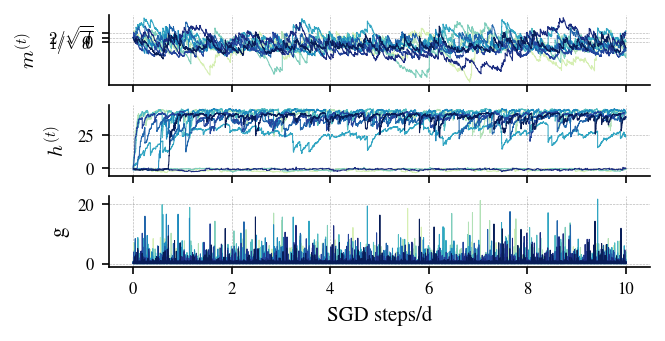

In [27]:
ncols = 1
nrows = 3


width = double_w*0.5
figsize = (double_w*0.6, double_w*0.3)
col = colors[0]
cols_map = plt.get_cmap(cmaps[0])(np.linspace(0.2, 1,N_walkers))
set_font_sizes(conf='normal')
fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)


for i , key in enumerate(['overlaps','preactivations','grad']):
    ax = axes[i]
    ax.set_ylabel([r'$m^{(t)}$',r'$h^{(t)}$',r'g'][i])
    times = results['times']/d
    x = results[key]
    # ax.set_xlim(right=100)
    if i == nrows-1 : 
        ax.set_xlabel('SGD steps/d')
    if i == 0 : 
        # ax.axhline(0,ls='--')
        yticks = [i/np.sqrt(d) for i in range(0,3)]
        yticks_lab = [r'$0$']+[fr'${i}/\sqrt{{d}}$' for i in range(1,3)]
        ax.set_yticks(yticks,yticks_lab)
        # ax.set_ylim(0,2.2/np.sqrt(d))
        
        # ax.axhline(2/np.sqrt(d),ls='--')
    else:
        xticks = [0.0,0.2,0.4,0.6,0.8,1.0]
        # xticks_lab = [r'$0$',r'$0.2d$',r'$0.4d$',r'$0.6d$',r'$0.8d$',r'$d$']
        # ax.set_xticks(xticks,xticks_lab)
    if i == 2: x /= np.sqrt(d)
    ax.grid(ls='--',c='k',lw=0.3,alpha=0.3)

    for w in range(N_walkers):
        ax.plot(times,x[:,w],color=cols_map[w],lw=0.5)


# fig.savefig(f'../logs/online_sgd_d{d}_p{p}_k{k}_teacher_{teacher}_student{student}_lr{lr/np.sqrt(d) :.4}.png', dpi=300, bbox_inches='tight')

In [ ]:
h = np.linspace(-5,5,100)
h_star = 1 #np.random.normal()

for d in [100,500,1000]:
    m = h_star*h/(2*d - h**2)
    plt.plot(h,m,label=rf'$d = {d}$')

plt.legend()

# ODE

In [6]:
params = {
    'd': 600,
    'k': 5,
    'p': 0.001,
    'tau': 0.1,
    'teacher': 'He5',
    'student': 'tanh',
    'loss': 'corr',
    'h_star': 2.0,
    'c': 1,
    'scale': 'log'

}

d = params['d']
k = params['k']
params['p'] = 2*d**(-0.5*(k-1))

h_star = params['h_star']
tau = params['tau']
teacher = params['teacher']
student = params['student']
p = params['p']


# Initial conditions
m0 = 1.0/np.sqrt(d)
h0 = 0.5
# h0 = 2*params['h_star']*m0
state0 = [m0, h0]

# Time points
# s = np.linspace(0,d**(k),50)
# s = np.logspace(0,k,50,base=d)
s = np.linspace(0,k+1,50)
# Solve ODE
# solution,info = odeint(velocity_field, state0, s, args=(params,), full_output=1)

print(params['h_star'],h0)

solver = solve_ivp(velocity_field, [s[0], s[-1]],state0, t_eval=s,args=(params,), method='BDF')
s = solver.t
solution = solver.y.T
print(solver.message)
print(params)


2.0 0.5
The solver successfully reached the end of the integration interval.
{'d': 600, 'k': 5, 'p': 5.555555555555556e-06, 'tau': 0.1, 'teacher': 'He5', 'student': 'tanh', 'loss': 'corr', 'h_star': 2.0, 'c': 1, 'scale': 'log'}


(0.0, 6.0)

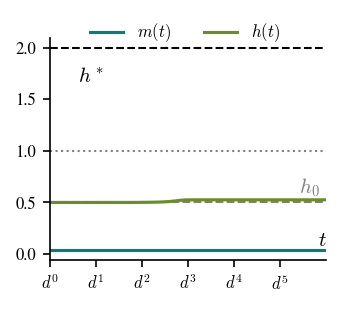

In [7]:
ncols = 1
nrows = 1
d = params['d']
width = double_w*0.3
figsize = (width, width *0.9)
set_font_sizes(conf='normal')
xticks = [i for i in range(0,k+1)]
xticks_lab = [rf"$d^{i}$" for i in range(0,k+1)]
col = pc_colors[:2]
# cols_map = plt.get_cmap(cmaps[0])(np.linspace(0.5, 1, dataset_size))

fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)

ax = axes

for i , h in enumerate([h0,h_star]):
    ax.axhline(h, ls='--', color=['gray','black'][i], lw=1)
    ax.text([0.9,0.1][i],[0.3,0.8][i] , [r'$h_0$',r'$h^*$'][i], color=['gray','black'][i],transform=ax.transAxes)

ax.axhline(1, ls=':', color='gray', lw=1)
# Plot the results
for i , lb in enumerate([ r'$m(t)$',r'$h(t)$']):
    norm = np.max(solution[:,i]) if i == 1 else 1
    norm=1
    ax.plot(s,solution[:, i]/norm, label=lb,color=col[i])

# ax.set_ylim(top=2.2)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xticks(xticks,xticks_lab)
ax.set_xlabel(r'$t$',loc='right',labelpad=-30)
ax.legend(frameon=False,loc=(0.12,0.94),ncols=2)
# ax.axhline(2*params['h_star']/(m0+1/m0),color='red')

# ax.set_ylim(0.5*m0,2.2)
ax.set_xlim(0,s[-1])

# fig.savefig(f'../logs/evolution_d{d}_p{p}_k{k}_teacher_{teacher}_student{student}_tau{tau}.png', dpi=300, bbox_inches='tight')

TypeError: cannot unpack non-iterable int object

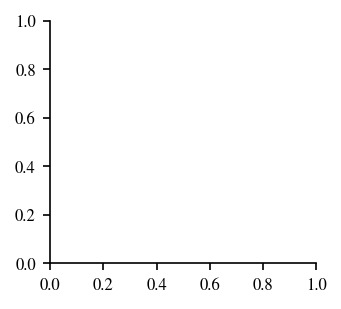

In [198]:
ncols = 1
nrows = 1
d = params['d']
width = double_w*0.3
figsize = (width, width *0.9)
set_font_sizes(conf='normal')

col = colors[::-1]#[:2]
m = np.linspace(-1,1,100)
state = [m, h0]
params['scale'] = 'linear'
# cols_map = plt.get_cmap(cmaps[0])(np.linspace(0.5, 1, dataset_size))

fig , axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, layout='constrained', sharex=True)
ax = axes




for i , k in enumerate([3,4,5]):
    params['k'] = k
    dm  = velocity_field(state,0,params)[0]
    ax.plot(m,dm,color=col[i],label=rf'$k = {k}$')

ax.legend(frameon=False,fontsize=FONTSIZES['xs'],loc=(0.05,0.55))
ax.set_xlabel(r'$m$',loc='right',labelpad=-30)
ax.set_ylabel(r'$\frac{dm}{dt}$',rotation=0,loc='top',labelpad=-40)
ax.grid(ls='--',c='k',lw=0.3,alpha=0.3)

# fig.savefig(f'../logs/dmdt_d{d}_p{p}_teacher_{teacher}_student{student}.png', dpi=300, bbox_inches='tight')

In [106]:
params = {
    'd': 1000,
    'k': 5,
    'p': 0.0001,
    'tau': 1,
    'teacher': 'He5',
    'student': 'tanh',
    'loss': 'corr',
    'h_star': 2.0,
    'c': 1,
    'scale': 'linear'

}


d = params['d']
k = params['k']
h_star = params['h_star']
tau = params['tau']
teacher = params['teacher']
student = params['student']
p = params['p']

# Create a grid of points
m = np.linspace(-1, 1, 100)[1:-1]
h = np.linspace(-3, 3, 100)
M, H = np.meshgrid(m, h)

# Compute the velocity field at each point
U, V = velocity_field(0,[M, H] , params)

# Compute the magnitude of the velocity
magnitude = np.sqrt(U**2 + V**2)

# Normalize vectors to unit length for quiver
U_unit = U / magnitude
V_unit = V / magnitude

Text(0.5, 1.0, '$p=0.0001$')

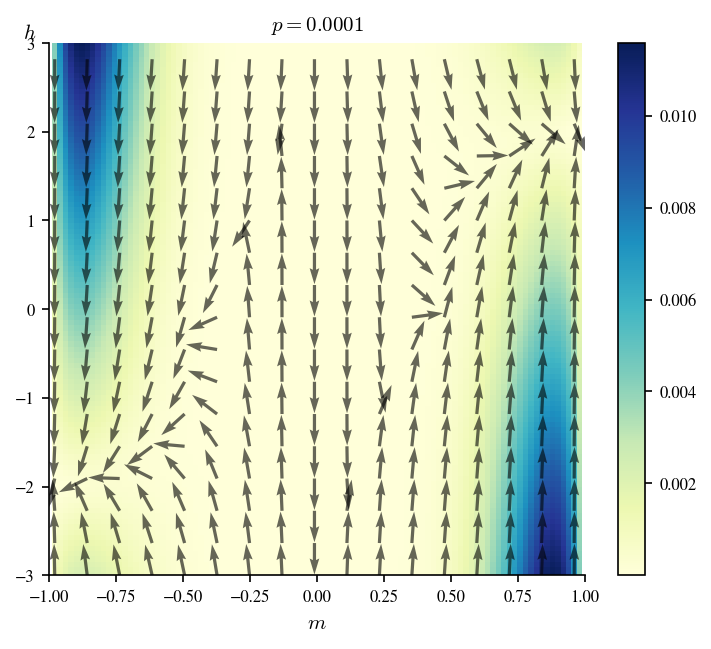

In [107]:
cmap = pc_cmaps[0]
width = double_w*0.8
figsize = (width, width *0.8)
set_font_sizes(conf='normal')

fig, ax = plt.subplots(figsize=figsize)
# Plot the heatmap of the magnitude
c = ax.pcolormesh(M, H, magnitude, cmap=cmap,alpha=1)
fig.colorbar(c, ax=ax)

# Plot nuk-lines
# hnuk = 2*h_star/(m+1/m)
hnuk = h_star/m
# ax.plot(m,hnuk,lw=1,alpha=1,color=colors[0],label=r'$dh/dt = 0$')

a = 6

# Plot the normalized velocity vectors
ax.quiver(M[::a,::a], H[::a,::a], U_unit[::a,::a], V_unit[::a,::a], color='black', alpha=0.6,scale=17, width=0.006)

ax.set_xlim(-1,1)
ax.set_ylim(-3,3)
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'$h$',loc='top',rotation=0,labelpad=-10)


ax.set_title(fr'$p={params['p']}$')
# ax.legend(frameon=True,loc=(0.15,0.8))
# ax.axhline(h_star)
# ax.axhline(-h_star)


# fig.savefig(f'../logs/vectorfield_notrivial_d{d}_p{p}_k{k}_teacher_{teacher}_student{student}_tau{tau}.png', dpi=300, bbox_inches='tight')

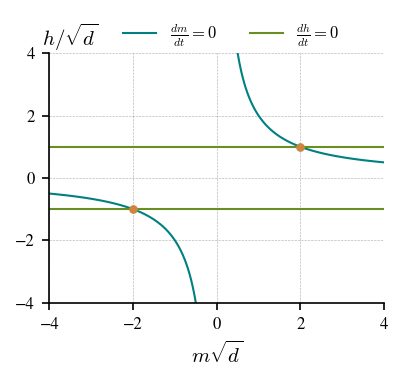

In [144]:
width = double_w*0.3
figsize = (double_w*0.4, double_w*0.3)
set_font_sizes(conf='normal')

d = 1000
h_star = 2
m = np.linspace(0.1,4,100)[1:]
mnull = np.linspace(-4,4,100)



fig, ax = plt.subplots(figsize=figsize)

ax.plot(m,h_star/(m),lw=1,alpha=1,color=colors[0],label=r'$\frac{dm}{dt} = 0$')
ax.plot(-m,-h_star/(m),lw=1,alpha=1,color=colors[0])

# ax.plot(mnull*np.sqrt(d),h,lw=1,alpha=1,color=colors[1],label=r'$dh/dt=0$')
ax.axhline(1,lw=1,alpha=1,color=colors[1],label=r'$\frac{dh}{dt}=0$')
ax.axhline(-1,lw=1,alpha=1,color=colors[1])

ax.scatter([-2,2],[-1,1],marker='.',color=colors[2],zorder=5,s=40)


ax.legend(frameon=False,ncols=2,loc=(0.2,0.99))
ax.grid(ls='--',c='k',lw=0.3,alpha=0.3)
ax.set_xlabel(r'$m \sqrt{d}$')
ax.set_ylabel(r'$h/\sqrt{d}$',loc='top',rotation=0,labelpad=-40)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)


fig.savefig(f'../logs/fixed_pts_d{d}_p{p}_k{k}_teacher_{teacher}_student{student}.png', dpi=300, bbox_inches='tight')


# Derivatives

In [48]:
# Decomposing parameters
# d = 300
c = 0.14
k = 3
tau = 1
teacher_fun = activations['He3'][0]
student_fun, student_deriv = activations['tanh']

ds = [20,40,80,160,320,640]

data = {}
for d in ds:
    m = 1/np.sqrt(d)

    Nit = 100

    h_star = np.random.randn(Nit)
    h = np.random.randn(Nit)

    p = 8*d**(0.5*(k-1))

    # Auxiliar quantities
    g = teacher_fun(h_star)
    sig = student_fun(h)
    sig_prime = student_deriv(h)
    sig_2prime = -2*sig*sig_prime

    F = p*g*sig_prime*(h_star-h*m) + (1-p)*c*k*m**(k-1)*(1-m**2)
    G = p*g*sig_prime*(d-h*h) + (1-p)*c*k*m**(k-1)*(h_star-m*h)

    dFdm = -p*h*g*sig_prime + (1-p)*c*m**(k-2)*(k-1-m**2*(k+1))
    dFdh = p*g*(sig_2prime*(h_star-h*m) - m*sig_prime)
    dGdm = (1-p)*c*m**(k-2)*((k-1)*(h_star-m*h) - m*h)
    dGdh = p*g*(sig_2prime*(d-h**2) - 2*h*sig_prime)

    # Derivatives
    # m_dot = 1/(2*d*m*tau) * F**2
    # h_dot = 1/(d*m*tau) * F * G - h/(2*d*m*tau) * F**2

    # Jacobian 
    dmdm = -1/(2*m*m*d) * F**2 + 1/(m*d) * F * dFdm
    dmdh = 1/(m*d) * F * dFdh
    dhdm = -1/(m*m*d) * F * G + 1/(m*d) * (F*dGdm + G * dFdm) + h/(d*m**3) * F**2 - h/(d*m*m) * F * dFdm
    dhdh = 1/(m*d) *  (F*dGdh + G * dFdh) - F**2/(2*d*m*m) - h/(d*m*m) * F * dFdh

    J = np.array([[dmdm,dmdh],
                [dhdm,dhdh]]).transpose((2,0,1)) #/ d**(k-0.5)

    print(J.shape)
    vals , vecs = np.linalg.eig(J)
    data[d] = [vals,vecs]

(100, 2, 2)
(100, 2, 2)
(100, 2, 2)
(100, 2, 2)
(100, 2, 2)
(100, 2, 2)


In [16]:
vals.shape

(100, 2)

(array([ 1., 93.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.36914251, -0.06403248,  0.24107755,  0.54618758,  0.8512976 ,
         1.15640763,  1.46151766,  1.76662769,  2.07173772,  2.37684774,
         2.68195777,  2.9870678 ,  3.29217783,  3.59728785,  3.90239788,
         4.20750791,  4.51261794,  4.81772797,  5.12283799,  5.42794802,
         5.73305805,  6.03816808,  6.3432781 ,  6.64838813,  6.95349816,
         7.25860819,  7.56371822,  7.86882824,  8.17393827,  8.4790483 ,
         8.78415833]),
 <BarContainer object of 30 artists>)

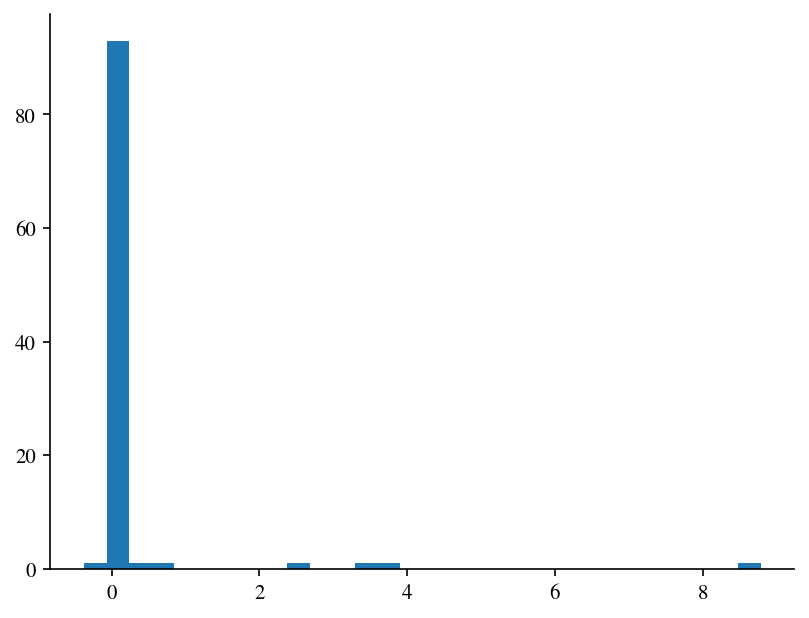

In [19]:
plt.hist(vals[:,0],bins=30)

In [51]:
vals.shape

(100, 2)

[272036.34866276 790507.05478932]
0
99
[ 15690.12777188 793705.76908052]
1
[  518084.30834105 17236497.2833588 ]
2
[  386099.81391107 77366538.66851461]
3
[4.97310805e+06 5.14034360e+08]
4
[4.64009414e+07 1.91437362e+10]
5


c:\Users\crise\OneDrive - SISSA\Documents\SISSA\SISSA 2nd YEAR\SGD\.venv\Lib\site-packages\matplotlib\transforms.py:1854: ComplexWarning: Casting complex values to real discards the imaginary part
  return affine_transform(values, mtx)


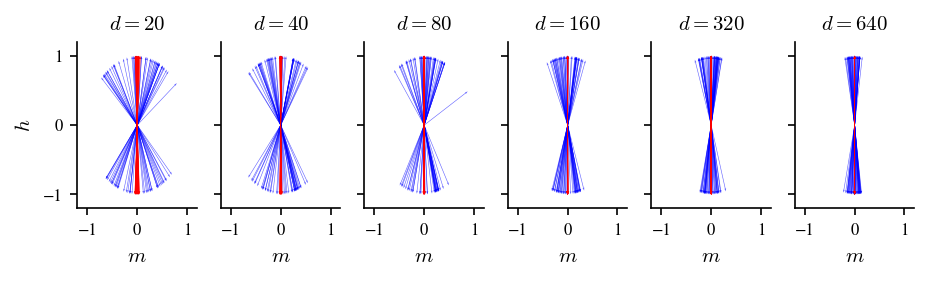

In [53]:
# Plot the basis vectors using quiver
ncols = len(ds)
nrows = 1

width = double_w
figsize = (width, width*0.2)
set_font_sizes(conf='normal')

fig, axes = plt.subplots(nrows,ncols,figsize=figsize,sharey=True)

for j , d in enumerate(ds):
    ax = axes[j]
    vals , vecs = data[d]
    print(vals.std(axis=0))
    # Plot all other vectors in blue
    for i in range(1, Nit):
        # First element of the i-th basis
        ax.quiver(0, 0, vecs[i, 0, 0], vecs[i, 1, 0], 
                color='blue', scale=1, scale_units='xy', 
                angles='xy', width=0.005, alpha=0.6)

    for i in range(1, Nit):
        # First element of the i-th basis
        ax.quiver(0, 0, vecs[i, 0, 1], vecs[i, 1, 1], 
                color='red', scale=1, scale_units='xy', 
                angles='xy', width=0.005, alpha=0.6)


# # Set equal aspect ratio and add grid
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)

# # Add labels and title
    ax.set_xlabel(r'$m$')
    print(j)
    if j == 0:
        print(i)
        ax.set_ylabel(r'$h$')
    ax.set_title(fr'$d = {d}$')
# ax.set_title(f'Eigenvectors from Jacobian (Nit={Nit})')
# ax.legend()

    # Set reasonable axis limits
    max_val = np.max(np.abs(vecs))
    ax.set_xlim(-max_val*1.2, max_val*1.2)
    ax.set_ylim(-max_val*1.2, max_val*1.2)

# plt.tight_layout()
# plt.show()

# fig.savefig(f'../logs/eigenvecs_k{k}_teacher{'He3'}_student{'tanh'}.png', dpi=300, bbox_inches='tight')

# Match p scale

In [66]:
params = {
    'd': 1000,
    'k': 3,
    'tau': 0.01,
    'p': 0.5,
    'teacher': 'He3',
    'student': 'tanh',
    'loss': 'corr',
    'c': 1,
    'scale': 'log',
    'h_star': 2.0,
    's_ref' : 5
}


d = params['d']
k = params['k']
tau = params['tau']
teacher = params['teacher']
student = params['student']

m0 = 1.0/np.sqrt(d)
s_base = np.linspace(0,1,200)

# Create a grid of points
m = np.linspace(-1, 1, 100)[1:-1]
h = np.linspace(-3, 3, 100)
M, H = np.meshgrid(m, h)


xps = [2 , 3 , 4 ]

Nit = 4

data = {}
for xp in xps:
    params['alpha'] = xp
    print(params['alpha'])
    # Compute the velocity field at each point
    # U, V = velocity_field(0,[M, H] , params)
    data[xp] = {
        'iters':[],
        # 'vec':[U,V]
    }
    for i in range(Nit): 
        # Initial conditions
        #np.random.randn()
        h0 = np.random.normal(loc=0.0, scale=1.0)
        
        state0 = [m0, h0]
        solver = solve_ivp(velocity_field, [s_base[0], s_base[-1]],state0, t_eval=s_base, args=(params,), method='Radau')
        
        solution = solver.y.T
        s = solver.t
        data[xp]['iters'].append([s,solution])
        # data[p0].append(solve_with_timeout(params,s,m0))
        print(solver.message)


2
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


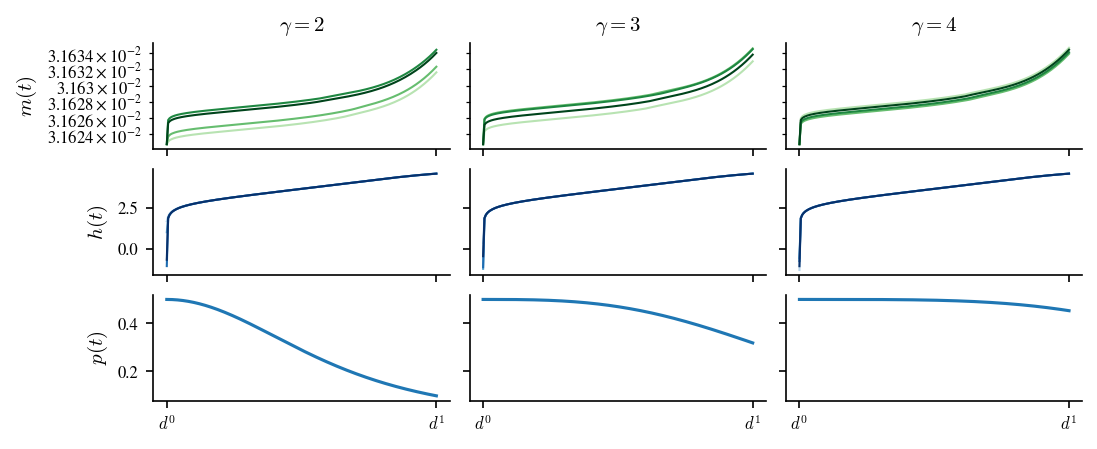

In [67]:
ncols , nrows = len(xps) , 3
width = double_w
figsize = (width, width*0.4)  # Make figure more square
set_font_sizes(conf='normal')

xtk = [i for i in range(k+1)]
xlb = [rf'$d^{i}$' for i in range(k+1)]

colors = [ plt.get_cmap(cmp)(np.linspace(0.3,1,Nit)) for cmp in pc_cmaps[::-1]]
cmap = pc_cmaps[0]

fig , axes = plt.subplots(nrows,ncols,figsize=figsize,sharex=True,sharey='row',layout='constrained')

for i , lb in enumerate([r'$m(t)$',r'$h(t)$',r'$p(t)$']):
    cols = colors[i]
    for ip , p0 in enumerate(xps): 
        ax = axes[i,ip]
        if i==0: ax.set_yscale('log')
        ax.set_xticks(xtk,xlb)
        if ip == 0 : ax.set_ylabel(lb)
        if i == 0 : ax.set_title(rf'$\gamma = {p0}$')
        if i < 2:
            for it in range(Nit): 
                s , x = data[p0]['iters'][it]
                ax.plot(s,x[:,i],color=cols[it],lw=1,)
        else:
            s_ref = params['s_ref']
            alpha = p0
            k = params['k']
            s = np.linspace(0,1,500)
            p = params['p']/(1  +  d**(0.25*(k-1))*(s/s_ref)**alpha)**2
            ax.plot(s,p)
        # if i == 1 and ip == 0: 
            # ax.axhline(2*h_star / (m0 + 1/m0))
        # if i==1: ax.axhline(2)
        # if i==0 : ax.set_ylim(bottom=0)

# for ip , p0 in enumerate(ps):
#     print(ip)
#     ax = axes[-1,ip]
#     # Make the subplot square by setting equal aspect ratio
#     # ax.set_aspect('equal')
#     U , V = data[p0]['vec']
#     # Compute the magnitude of the velocity
#     magnitude = np.sqrt(U**2 + V**2)

#     # Normalize vectors to unit length for quiver
#     U_unit = U / magnitude
#     V_unit = V / magnitude
#     c = ax.pcolormesh(M, H, magnitude, cmap=cmap,alpha=1)
#     fig.colorbar(c, ax=ax)
#     a = 6
#     # Plot the normalized velocity vectors
#     ax.quiver(M[::a,::a], H[::a,::a], U_unit[::a,::a], V_unit[::a,::a], color='black', alpha=0.6,scale=25, width=0.009)
#     # for it in range(Nit): 
#     #     s , x = data[p0]['iters'][it]
#     #     ax.plot(x[:,0],x[:,1],lw=1,)


# fig.savefig(f'../logs/pvst_k{k}_teacher{'He3'}_student{'tanh'}.png', dpi=300, bbox_inches='tight')

In [5]:
s = np.linspace(0,3,200)
xp = params['xp']
gam0 = params['gam0']
p = d**(-gam0-xp*s*(k-1))
plt.plot(s,p)
plt.grid()

KeyError: 'xp'

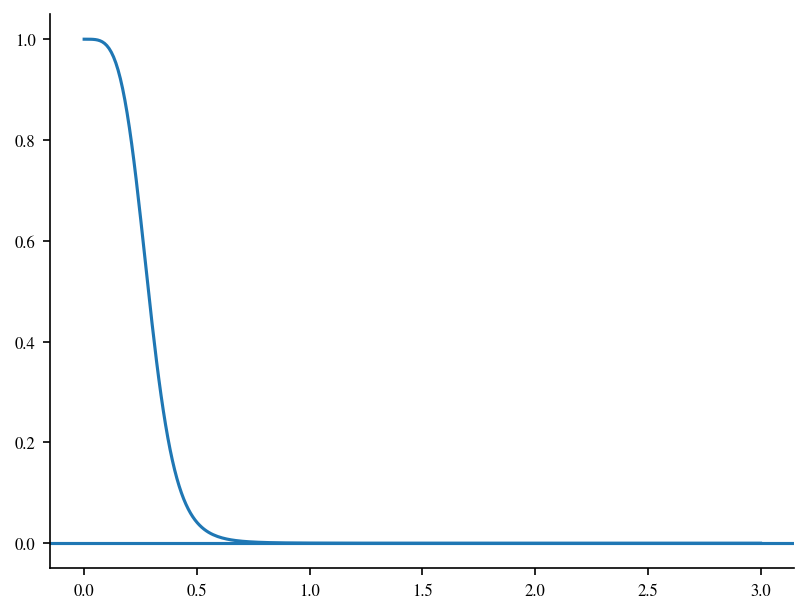

In [53]:
d = 1000
k = 5
alpha=4
x0 = 2
x = np.linspace(0,3,300)
y = 1/(1  +  d**(0.25*(k-1))*(x/x0)**alpha)**2
plt.plot(x,y)
# plt.yscale('log')
plt.axhline(d**(-0.5*(k-1)))